# Netflix Catalog — Exploratory Data Analysis (EDA)

This notebook explores a publicly available Netflix catalog dataset.

**Goals**
- Understand catalog composition (Movies vs TV Shows)
- Inspect runtime (mins) vs seasons distributions
- Explore genre and country distributions
- Explore cast-size patterns and “unique actors per genre”

## Reproducibility & Assumptions

- The dataset is *catalog-level* metadata (no user watch history).
- File paths are relative so this notebook runs after cloning the repo.
- Cleaning is handled by `clean_streaming_df()` from `streaming_func.py`.

In [28]:
# Import core libraries and project utilities
from pathlib import Path

import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt

from streaming_func import clean_streaming_df, unique_actors_per_genre, plot_top_unique_actors, plot_top_countries

In [29]:
# Loading Netflix dataset & info for understanding of present structure & content
DATA_DIR = Path("data")
netflix_df = pd.read_csv(DATA_DIR / "netflix_titles.csv")

netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Cleaning

Here, we standardise:
- column names
- multi-value columns (`cast`, `country`, `listed_in`) into Python lists
- duration into two numeric columns:
  - `duration_mins` for Movies
  - `duration_seasons` for TV Shows

### Note on platform-specific cleaning

Earlier iterations of this notebook included an Amazon-specific cleaning function.
This logic has been moved into `streaming_func.py` to keep notebooks lightweight, reusable, & focused on analysis.

The `clean_streaming_df()` function standardises column formats & converts multi-value fields (cast/country/genres) into lists, which enables consistent EDA across platforms.

In [30]:
clean_netflix_df = clean_streaming_df(netflix_df)
clean_netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_mins,duration_seasons
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,[],[United States],"September 25, 2021",2020,PG-13,90 min,[Documentaries],"As her father nears the end of his life, filmm...",90,<NA>
1,s2,TV Show,Blood & Water,NaN,"[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...",[South Africa],"September 24, 2021",2021,TV-MA,2 Seasons,"[International TV Shows, TV Dramas, TV Mysteries]","After crossing paths at a party, a Cape Town t...",<NA>,2
2,s3,TV Show,Ganglands,Julien Leclercq,"[Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nab...",[],"September 24, 2021",2021,TV-MA,1 Season,"[Crime TV Shows, International TV Shows, TV Ac...",To protect his family from a powerful drug lor...,<NA>,1
3,s4,TV Show,Jailbirds New Orleans,NaN,[],[],"September 24, 2021",2021,TV-MA,1 Season,"[Docuseries, Reality TV]","Feuds, flirtations and toilet talk go down amo...",<NA>,1
4,s5,TV Show,Kota Factory,NaN,"[Mayur More, Jitendra Kumar, Ranjan Raj, Alam ...",[India],"September 24, 2021",2021,TV-MA,2 Seasons,"[International TV Shows, Romantic TV Shows, TV...",In a city of coaching centers known to train I...,<NA>,2


## Quick dataset breadth checks (genres & production countries)

Before plotting, we compute how many unique genres & countries appear in the catalog.
This is a simple “breadth” sanity-check that also helps interpret long-tail plots later.

In [31]:
# Extracting unique genre types & countries from the 'listed_in' & 'country' columns respectively for Amazon Prime dataset
netflix_genres = sorted(set(chain.from_iterable(clean_netflix_df["listed_in"])))
netflix_countries = sorted(set(chain.from_iterable(clean_netflix_df["country"])))

print(f'Total unique genres for Netflix media: {len(netflix_genres)}')
print(f'Total unique production countries for Netflix media: {len(netflix_countries)}')

Total unique genres for Netflix media: 42
Total unique production countries for Netflix media: 122


## Split into Movies vs TV Shows

Many analyses differ by type (e.g. duration in minutes vs seasons), so we create two filtered dataframes.

In [32]:
# Movies-only & TV-Shows-only dataframe partitions of the cleaned Amazon Prime dataset
clean_shows_df = clean_netflix_df[clean_netflix_df["type"] == "TV Show"].copy()
clean_movies_df = clean_netflix_df[clean_netflix_df["type"] == "Movie"].copy()

clean_shows_df.shape, clean_movies_df.shape, clean_netflix_df.shape

((2676, 14), (6131, 14), (8807, 14))

## Movie runtime distribution (minutes)

We inspect the distribution of movie runtimes to understand typical lengths & whether outliers exist.


### Movie Runtime Distribution

To understand the typical length of movies on Netflix, I visualised the
distribution of movie runtimes. Extreme outliers (very long runtimes, e.g.
special editions or misclassified entries) were excluded to avoid skewing the
visualisation.

The distribution shows a strong concentration around standard feature-length
films (~90 minutes), with a right-skewed tail representing longer productions.

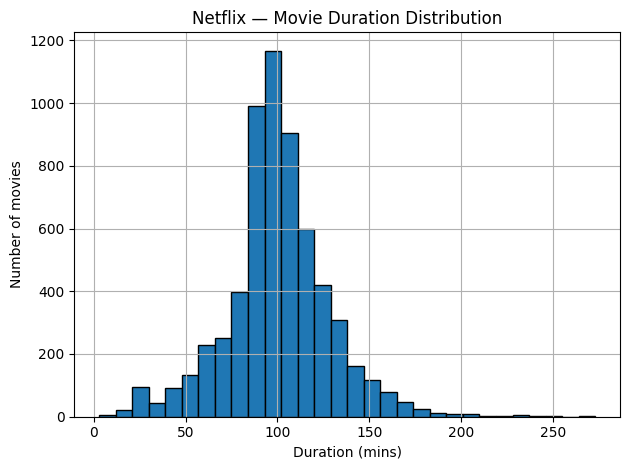

In [33]:
# Focus on typical feature-length films (exclude extreme outliers)
filtered_movies = clean_movies_df[clean_movies_df["duration_mins"] <= 300]

filtered_movies["duration_mins"].dropna().astype(int).hist(
    bins=30,
    edgecolor="black"
)

plt.title("Netflix — Movie Duration Distribution")
plt.xlabel("Duration (mins)")
plt.ylabel("Number of movies")
plt.tight_layout()
plt.show()

> *Findings:* Movie runtimes cluster around typical feature-length durations, with a long tail of unusually short/long titles. Outliers are expected due to specials, compilations, & metadata noise.

## TV Show seasons distribution

Here, we inspect how many seasons TV shows on Netflix typically have. To keep the plot readable, we focus on shows up to a chosen season threshold (long-running outliers exist).

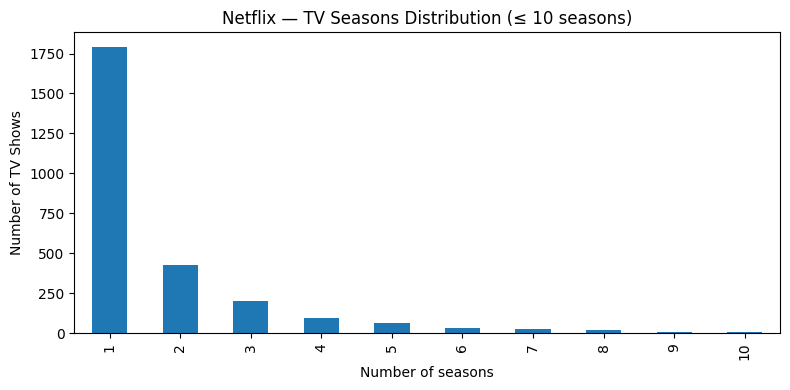

In [35]:
# Filtering for TV shows on Netflix with 10 seasons or less, as few tv shows ever suceed enough to exceed this number
max_seasons = 10

filtered_tv = clean_shows_df[clean_shows_df["duration_seasons"].notna() & (clean_shows_df["duration_seasons"] <= max_seasons)]

shows_ax = filtered_tv.groupby("duration_seasons").size().plot(kind="bar", figsize=(8,4))
shows_ax.set_title(f"Netflix — TV Seasons Distribution (≤ {max_seasons} seasons)")
shows_ax.set_xlabel("Number of seasons")
shows_ax.set_ylabel("Number of TV Shows")
plt.tight_layout()
plt.show()

> *Findings:* Most shows have relatively few seasons, with a small number of long-running series creating a long tail.
Filtering improves readability without changing the overall pattern.

## Cast size patterns

Cast lists are imperfect metadata but can still reveal structure:
- TV shows may have larger or more variable casts than movies
- long tails are expected (ensembles / anthology listings)

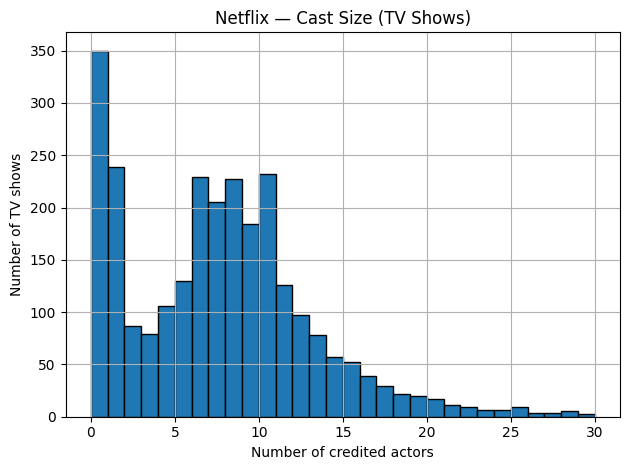

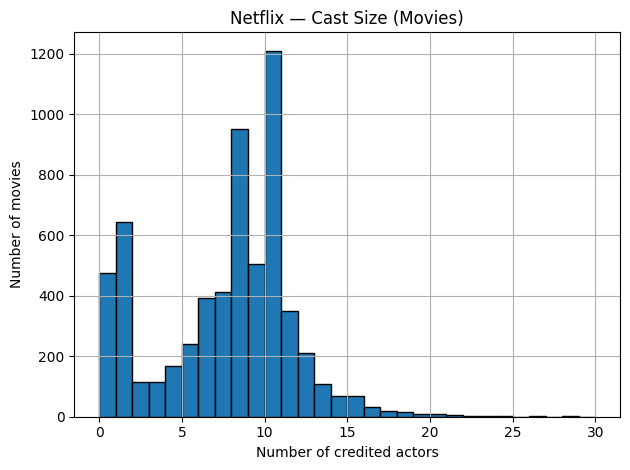

In [54]:
# Histograms of cast sizes in Movies & TV Shows on Amazon Prime
shows_cast = clean_shows_df.assign(cast_count=clean_shows_df["cast"].apply(len))
movies_cast = clean_movies_df.assign(cast_count=clean_movies_df["cast"].apply(len))

shows_cast["cast_count"].hist(bins=range(0, 31), edgecolor='black')
plt.title("Netflix — Cast Size (TV Shows)")
plt.xlabel("Number of credited actors")
plt.ylabel("Number of TV shows")
plt.tight_layout()
plt.show()

movies_cast["cast_count"].hist(bins=range(0, 31), edgecolor='black')
plt.title("Netflix — Cast Size (Movies)")
plt.xlabel("Number of credited actors")
plt.ylabel("Number of movies")
plt.tight_layout()
plt.show()

> *Findings:* Cast-size distributions are right-skewed (many small casts, fewer large ensembles).
This suggests using medians/quantiles when comparing platforms rather than means.

## Unique cast members (sanity check)

We compute the number of unique credited cast names across the catalog.
This is a rough indicator of metadata richness & helps interpret genre/cast aggregation later.

In [37]:
# Extracting unique cast members from the Netflix dataset
netflix_unique_cast = sorted(
    set(actor.strip() for actor in chain.from_iterable(clean_netflix_df["cast"]) if isinstance(actor, str) and actor.strip())
)

print(f"Total unique cast members (Netflix): {len(netflix_unique_cast)}")

Total unique cast members (Netflix): 36439


## Genre-level aggregation (using exploded rows)

In the dataframes of the streaming service, genres are multi-label. To aggregate per genre, we explode `listed_in` so each title contributes to each of its genres.
We then compute cast-related aggregates per genre to explore whether some genres tend to have larger ensembles of cast.

In [38]:
movies_exploded = clean_movies_df.explode("listed_in").assign(cast_count=clean_movies_df["cast"].apply(len))
shows_exploded  = clean_shows_df.explode("listed_in").assign(cast_count=clean_shows_df["cast"].apply(len))

movie_genre_cast = movies_exploded.groupby("listed_in")["cast_count"].sum().sort_values(ascending=False)
show_genre_cast  = shows_exploded.groupby("listed_in")["cast_count"].sum().sort_values(ascending=False)

print(f'{movie_genre_cast.head(10)} \n\n{show_genre_cast.head(10)}')

listed_in
Dramas                      20767
International Movies        20491
Comedies                    15185
Action & Adventure           8054
Independent Movies           6297
Children & Family Movies     5601
Romantic Movies              5214
Thrillers                    4821
Horror Movies                3066
Music & Musicals             2399
Name: cast_count, dtype: int64 

listed_in
International TV Shows       11210
TV Dramas                     7467
TV Comedies                   4458
Crime TV Shows                3931
Kids' TV                      3210
Romantic TV Shows             2890
Anime Series                  2123
Spanish-Language TV Shows     1813
TV Action & Adventure         1786
British TV Shows              1379
Name: cast_count, dtype: int64


> *Findings:* Genre aggregates show strong concentration: a small number of genres dominate total credited cast counts.
This likely reflects both catalog size per genre & metadata completeness.

## Unique actors per genre (top N)

We estimate how many distinct cast names appear within each genre.
This is not a perfect measure (metadata quality varies), but it’s a useful proxy for genre “breadth”.

> *Note:* I initially explored a pie chart for this comparison, but switched to a horizontal bar chart for improved readability and easier comparison across genres.

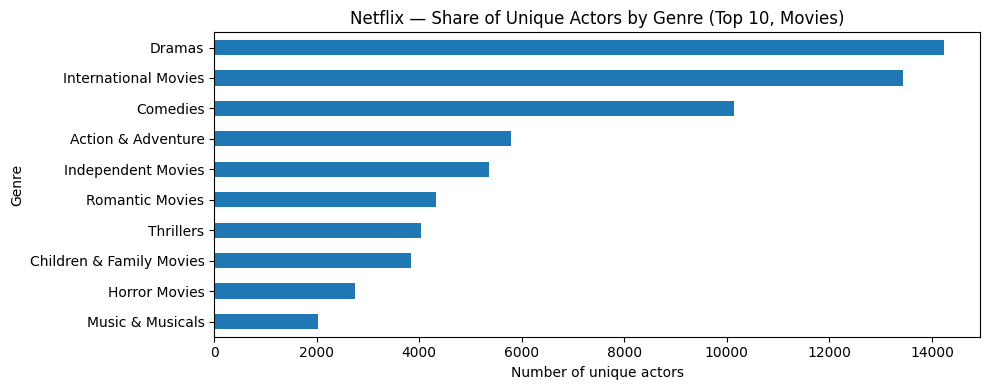

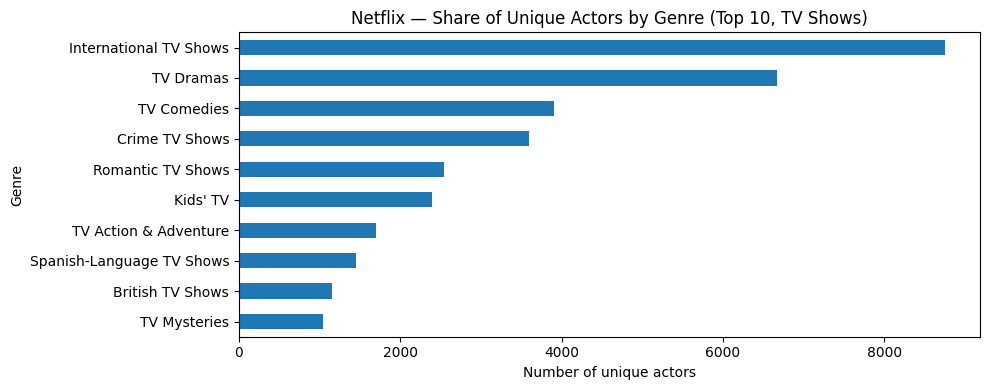

In [39]:
movie_unique_actors_per_genre = unique_actors_per_genre(clean_movies_df)
tv_unique_actors_per_genre = unique_actors_per_genre(clean_shows_df)

plot_top_unique_actors(movie_unique_actors_per_genre, "Netflix — Share of Unique Actors by Genre (Top 10, Movies)")
plot_top_unique_actors(tv_unique_actors_per_genre, "Netflix — Share of Unique Actors by Genre (Top 10, TV Shows)")

> *Note:* I initially plotted two very similar pie charts for a clear visual comparison between movie & tv show media on Netflix, but ended up choosing to switch to wrapping them with an external function in `streaming_func.py` & plotting them as horizontal bar charts to ensure consistent formatting & easier comparison.

### Country of Production (Top N)

To analyse geographic production patterns, country lists are exploded so each country
contributes independently to aggregate counts.

A horizontal bar chart is used instead of a pie chart to improve readability & enable
clear comparison across countries, particularly where distributions are skewed.

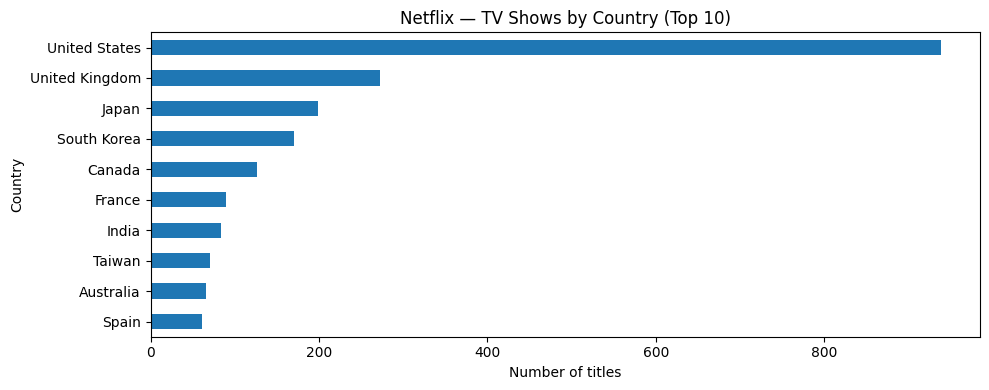

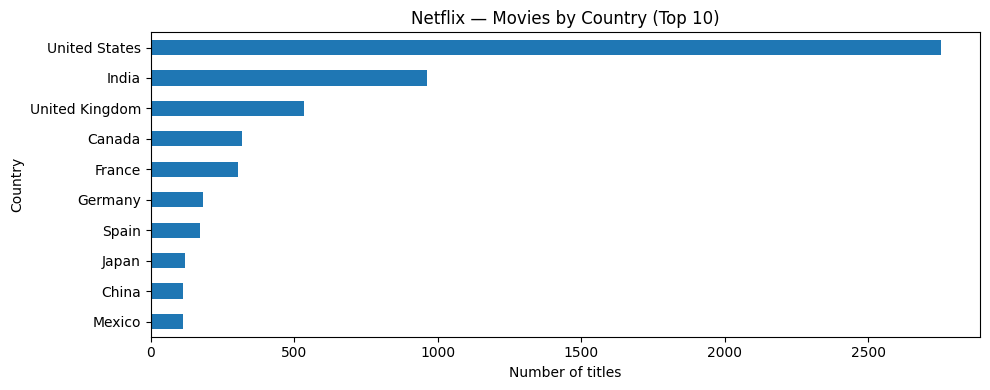

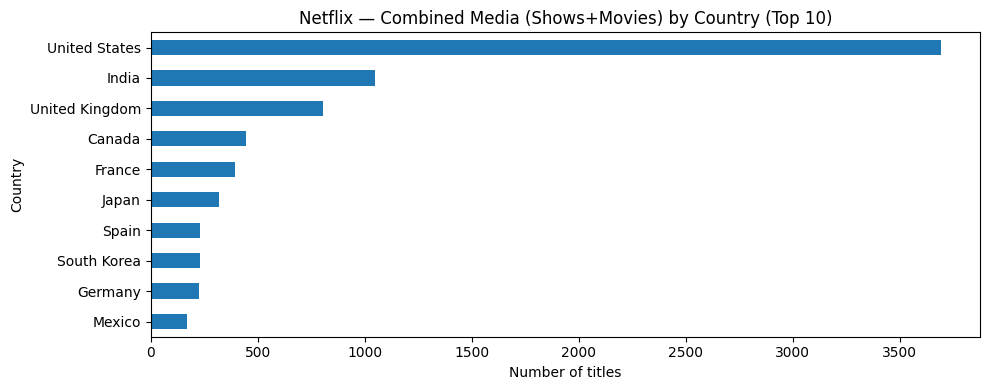

In [52]:
plot_top_countries(clean_shows_df["country"], "Netflix — TV Shows by Country (Top 10)", top_n=10)
plot_top_countries(clean_movies_df["country"], "Netflix — Movies by Country (Top 10)", top_n=10)
plot_top_countries(clean_netflix_df["country"], "Netflix — Combined Media (Shows+Movies) by Country (Top 10)", top_n=10)

### *Observations on countries of streaming media production*
+ The catalogue is heavily dominated by the United States, with India in 2nd & the UK coming in 3rd in movies & combined media, but forming a clear 2nd tier with India in total media
+ Movies show a stronger long-tail than TV (more countries appear in the top 10 / counts spread out faster).
+ Combined media largely mirrors movies because movies typically outnumber shows (if true in your dataset).